# **Tutorial: PINN simulation with JINNAX**

In this tutorial, we present the main features of the JINNAX package for simulating Physics Informed Neural Networks (PINN) in JAX. The purpose of JINNAX is to simulate the training of PINN to approximate the solution of the PDE

\begin{align*}
  \mathcal{N}_{x,t}[u(x,t)] &= f(x,t), \ \ x \in \Omega, \ t \in (t_{l},t_{u}] \\
  u(x,t) &= g(x,t), \ \ x \in \partial \Omega, \ t \in (t_{l},t_{u}]\\
  u(x,t_{l}) &= h(x)\ \ \ , \ \ x \in \bar{\Omega}
\end{align*}

in which $\mathcal{N}_{x,t}$ is a spatial-temporal differential operator, and $\Omega = (x_{l},x_{u})^{d}$ for $d \geq 1$ is the open d-dimensional cube.

The simulation pipeline in JINNAX has three steps:

1.   **Data generation**: Generate data in $\bar{\Omega} \times [t_{l},t_{u}]$
2.   **Training**: Train a PINN with the generated data
3.   **Evaluation**: Evaluate the trained PINN

This tutorial will cover how these steps can be performed with JINNAX. The documentation of JINNAX is available [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax.html).


### **Import JINNAX**

The latest version of JINNAX can be imported from Github. It has `data` and `nn` modules.

In [1]:
#Install genree, jinnax and dill
import os
os.system("pip3 install dill") #For saving results
os.system("pip3 install --upgrade git+https://github.com/dmarcondes/genree") #For error estimation
os.system("pip3 install --upgrade git+https://github.com/dmarcondes/JINNAX")

#Import jinnax
from jinnax import data as jd
from jinnax import nn as nn

### **Step 1: Data generation**

Data is generated by sensors placed in $\bar{\Omega}$ which realize measures over time, as follows:

*  **Sensor data**: There are $N_{s}^{d}, N_{s} > 1,$ sensors in $\Omega$, placed either in a grid or in uniformly sampled positions. These sensors provide measures at $N_{ts}$ times in a grid of $(t_{l},t_{u}]$ or at $N_{ts}$ times uniformly sampled from $(t_{l},t_{u}]$. The sensors have a mean-zero Gaussian noise with variance $\sigma_{s}^{2} \geq 0$. The sensor points are of form
$$\left(x_{i}^{(s)},t_{j}^{(s)},u(x_{i}^{(s)},t_{j}^{(s)})) + \epsilon_{i,j}^{(s)}\right), \ i = 1,\dots,N_{s}^{d}, j = 1, \dots, N_{ts}$$
in which $\epsilon_{i,j}^{(s)} \sim N(0,\sigma_{s}^{2})$ are independet random variables.

* **Initial data**: There are $N_{0}$ initial points (with $t = t_{l}$) in a grid of $\bar{\Omega}$ or uniformly sampled from this set. The sensors have a mean-zero Gaussian noise with variance $\sigma_{0}^{2} \geq 0$. The initial points are of form
$$\left(x_{i}^{(0)},t_{l},h(x_{i}) + \epsilon_{i}^{(0)}\right), \ i = 1,\dots,N_{0}$$
in which $\epsilon_{i}^{(0)} \sim N(0,\sigma_{0}^{2})$ are independet random variables.

* **Boundary data**: Observe that $\partial \Omega$ is formed by the edges of the n-cube $\bar{\Omega}$. In each edge of the n-cube $\bar{\Omega}$ there are $N_{b}$ sensor in either a grid or in uniformly sampled positions. These sensors provide measures at $N_{tb}$ times in a grid of $(t_{l},t_{u}]$ or at $N_{tb}$ times uniformly sampled from $(t_{l},t_{u}]$. Hence, there are $2N_{tb}$ boundary points if $d = 1$ and
$$N_{tb} \sum_{i=1}^{d} \binom{d}{i} 2^{i} N_{b}^{d-i} =  N_{tb} \left((N _{b} + 2)^{d} - N_{b}^{d}\right) $$
boundary points when $d > 1$. The sensors have a mean-zero Gaussian noise with variance $\sigma_{b}^{2} \geq 0$. The boundary points are of form
$$\left(x_{i}^{(b)},t_{j}^{(b)},g(x_{i}^{(b)},t_{j}^{(b)})) + \epsilon_{i,j}^{(b)}\right), \ i = 1,\dots,(N _{b} + 2)^{d} - N_{b}^{d}, j = 1, \dots, N_{tb}$$
in which $\epsilon_{i,j}^{(b)} \sim N(0,\sigma_{b}^{2})$ are independet random variables.

* **Collocation points**: There are $N_{c}^{d}$ collocation points in $\Omega$ placed either in a grid or in uniformly sampled positions. These spatial points are considered in $N_{ct}$ times in a grid of $(t_{l},t_{u}]$ or uniformly sampled from this set. The collocation points are of form
$$\left(x_{i}^{(c)},t_{j}^{(c)}\right), \ i = 1,\dots,N _{c}, j = 1, \dots, N_{tc}$$

Observe that in all types of data, the spatial and temporal points are selected independently and the data is actually the Cartesean product of the selected points. When $\sigma_{s}^{2} = 0, \sigma_{0}^{2} = 0$ or $\sigma_{b}^{2} = 0$, the respective data does not have noise. If $N_{s}N_{ts} = 0, N_{0} = 0, N_{tb} = 0$ or $N_{c}N_{tc} = 0$ then, respectively, no sensor, initial, boundary or collocation data is considered.

#### **JINNAX funtion for data generation**

Simulation data is generated by the function `generate_PINNdata` from the `data` module. Its documentation can be found [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/data.html#generate_PINNdata). The code below presents examples of data generated for one and two dimensional domains.

In [2]:
#One dimensional sensor data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Ns = 3,Nts = 2,d = 1,poss = 'grid',posts = 'grid')
print(data['sensor'])

[[0.25 0.5 ]
 [0.25 1.  ]
 [0.5  0.5 ]
 [0.5  1.  ]
 [0.75 0.5 ]
 [0.75 1.  ]]


In [3]:
#Two dimensional sensor data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Ns = 3,Nts = 2,d = 2,poss = 'grid',posts = 'grid')
print(data['sensor'])

[[0.25 0.25 0.5 ]
 [0.25 0.25 1.  ]
 [0.25 0.5  0.5 ]
 [0.25 0.5  1.  ]
 [0.25 0.75 0.5 ]
 [0.25 0.75 1.  ]
 [0.5  0.25 0.5 ]
 [0.5  0.25 1.  ]
 [0.5  0.5  0.5 ]
 [0.5  0.5  1.  ]
 [0.5  0.75 0.5 ]
 [0.5  0.75 1.  ]
 [0.75 0.25 0.5 ]
 [0.75 0.25 1.  ]
 [0.75 0.5  0.5 ]
 [0.75 0.5  1.  ]
 [0.75 0.75 0.5 ]
 [0.75 0.75 1.  ]]


In [4]:
#One dimensional boundary data
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nb = 0,Ntb = 3,d = 1)
print(data['boundary'])

[[0.         0.33333334]
 [0.         0.6666667 ]
 [0.         1.        ]
 [1.         0.33333334]
 [1.         0.6666667 ]
 [1.         1.        ]]


In [5]:
#Two dimensional boundary data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nb = 2,Ntb = 2,d = 2,posb = 'grid',postb = 'grid')
print(data['boundary'])

[[0.         0.         0.5       ]
 [0.         0.         1.        ]
 [0.         1.         0.5       ]
 [0.         1.         1.        ]
 [0.         0.33333334 0.5       ]
 [0.         0.33333334 1.        ]
 [0.         0.6666667  0.5       ]
 [0.         0.6666667  1.        ]
 [1.         0.         0.5       ]
 [1.         0.         1.        ]
 [1.         1.         0.5       ]
 [1.         1.         1.        ]
 [1.         0.33333334 0.5       ]
 [1.         0.33333334 1.        ]
 [1.         0.6666667  0.5       ]
 [1.         0.6666667  1.        ]
 [0.33333334 0.         0.5       ]
 [0.33333334 0.         1.        ]
 [0.6666667  0.         0.5       ]
 [0.6666667  0.         1.        ]
 [0.33333334 1.         0.5       ]
 [0.33333334 1.         1.        ]
 [0.6666667  1.         0.5       ]
 [0.6666667  1.         1.        ]]


In [6]:
#One dimensional initial data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,N0 = 10,d = 1,pos0 = 'grid')
print(data['initial'])

[[0.         0.        ]
 [0.11111111 0.        ]
 [0.22222222 0.        ]
 [0.33333334 0.        ]
 [0.44444445 0.        ]
 [0.5555556  0.        ]
 [0.6666667  0.        ]
 [0.7777778  0.        ]
 [0.8888889  0.        ]
 [1.         0.        ]]


In [7]:
#Two dimensional initial data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,N0 = 3,d = 2,pos0 = 'grid')
print(data['initial'])

[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  1.  0. ]
 [0.5 0.  0. ]
 [0.5 0.5 0. ]
 [0.5 1.  0. ]
 [1.  0.  0. ]
 [1.  0.5 0. ]
 [1.  1.  0. ]]


In [8]:
#One dimensional collocation data in a grid
u = lambda x,t: x*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nc = 3,Ntc = 3,d = 1,posc = 'grid')
print(data['collocation'])

[[0.25       0.33333334]
 [0.25       0.6666667 ]
 [0.25       1.        ]
 [0.5        0.33333334]
 [0.5        0.6666667 ]
 [0.5        1.        ]
 [0.75       0.33333334]
 [0.75       0.6666667 ]
 [0.75       1.        ]]


In [9]:
#Two dimensional collocation data in a grid
u = lambda x,t: x[0] + x[1]*t
data = jd.generate_PINNdata(u = u,xl = 0,xu = 1,tl = 0,tu = 1,Nc = 3,Ntc = 2,d = 2,posc = 'grid')
print(data['collocation'])

[[0.25 0.25 0.5 ]
 [0.25 0.25 1.  ]
 [0.25 0.5  0.5 ]
 [0.25 0.5  1.  ]
 [0.25 0.75 0.5 ]
 [0.25 0.75 1.  ]
 [0.5  0.25 0.5 ]
 [0.5  0.25 1.  ]
 [0.5  0.5  0.5 ]
 [0.5  0.5  1.  ]
 [0.5  0.75 0.5 ]
 [0.5  0.75 1.  ]
 [0.75 0.25 0.5 ]
 [0.75 0.25 1.  ]
 [0.75 0.5  0.5 ]
 [0.75 0.5  1.  ]
 [0.75 0.75 0.5 ]
 [0.75 0.75 1.  ]]


### **Step 2: Training the PINN**

A PINN is trained with the function `train_PINN` of the `nn` module. A fully connected architecture initialized with Glorot initialization is considered. The usual sum of the mean square error on sensor, boundary, initial and collocation points is considered as the loss function to be minimized:

$$\mathcal{L}(\boldsymbol{w}) = \mathcal{L}_{s}(\boldsymbol{w}) + \mathcal{L}_{b}(\boldsymbol{w}) + \mathcal{L}_{0}(\boldsymbol{w}) + \mathcal{L}_{c}(\boldsymbol{w})$$
in which
\begin{align*}
  \mathcal{L}_{s}(\boldsymbol{w}) =& \frac{1}{N_{s} N_{ts}} \sum_{i = 1}^{N_{ts}} \sum_{j = 1}^{N_{s}} \left|y_{i,j}^{(s)} - u_{\boldsymbol{w}}(x_{i}^{(s)},t_{j}^{(s)}) \right|^{2} \\
  \mathcal{L}_{b}(\boldsymbol{w}) =& \frac{1}{K N_{tb}} \sum_{i = 1}^{N_{tb}} \sum_{j = 1}^{K} \left|y_{i,j}^{(b)} - u_{\boldsymbol{w}}(x_{i}^{(b)},t_{j}^{(b)}) \right|^{2} \\
  \mathcal{L}_{0}(\boldsymbol{w}) =& \frac{1}{N_{0}} \sum_{j = 1}^{N_{0}} \left|y_{j}^{(0)} - u_{\boldsymbol{w}}(x_{i}^{(0)},0) \right|^{2} \\
  \mathcal{L}_{c}(\boldsymbol{w}) =& \frac{1}{N_{c} N_{tc}} \sum_{i = 1}^{N_{tc}} \sum_{j = 1}^{N_{c}} \left|\mathcal{N}_{x_{i}^{(c)},t_{j}^{(c)}}[u_{\boldsymbol{w}}(x_{i}^{(c)},t_{j}^{(c)})] - f(x_{i}^{(c)},t_{j}^{(c)})\right|^{2}
\end{align*}
where $u_{\boldsymbol{w}}$ is the fuction realized by the neural network with parameters $\boldsymbol{w}$ and $K = (N _{b} + 2)^{d} - N_{b}^{d}$ is the number of spatial boundary points. The $y$ points above are defined as

\begin{align*}
  y_{i,j}^{(s)} &= u(x_{i},t_{j}) + \epsilon_{i,j}^{(s)}\\
  y_{i,j}^{(b)} &= g(x_{i},t_{j}) + \epsilon_{i,j}^{(b)}\\
  y_{i}^{(0)} &= h(x_{i}) + \epsilon_{i}^{(0)}
\end{align*}
The L2 error on test data can be evaluated during and after training. The exact and predicted solution can be plotted for `d = 1`.

The documentation of the `train_PINN`function can be found [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/nn.html#train_PIIN).


### **Example 1: Forward Problem Viscous Burgers**

We will exemplify training PINN in JINNAX with the Viscous Burgers equation nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in (-1,1) \times (0,1]\,,\\
  &u(1,t) = u(-1,t) = 0\,, \quad t \in (0,1]\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad x \in [-1,1]\,, \\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity.

We consider the forward problem, in which there are no sensor data, but the initial and boundary conditions are known.

We start by computing the explicit solution and generating data. More details about this implementation may be found at the [SciML Course of the Scientific Machine Learning Lab - TAMIDS Texas A&M](https://colab.research.google.com/drive/1qBrbgevkSBqqYc8bOPiaoJG1MBrBrluN?usp=share_link).

In [10]:
#Import
import jax
from jax import numpy as jnp
from numpy.polynomial.hermite import hermgauss
import numpy as np

#Parameters of the simulation
nu = 0.01/np.pi # viscosity parameter
qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

#Domain
xl = -1.0
xu = +1.0
tl = 0.0
tu = 1.0

#Compute analytical solution u(x,t)
def u(x,t):
  u = 0
  if (t == 0.0):
    u = -jnp.sin(jnp.pi*x)
  else:
    top = 0.0
    bot = 0.0
    for qj in range(qn):
      c = 2.0*jnp.sqrt(nu*t)
      top = top - qw[qj]*c*jnp.sin(jnp.pi*(x - c*qx[qj]))*jnp.exp(-jnp.cos(jnp.pi*(x-c*qx[qj]))/(2.0*jnp.pi*nu))
      bot = bot + qw[qj]*c*jnp.exp(-jnp.cos(jnp.pi*(x - c*qx[qj]))/(2.0*jnp.pi*nu))
    u = top/bot
  return u

#PDE in the form pde(u,x,t) = 0
def pde(u,x,t):
    ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
    ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
    uxx = lambda x,t : jax.grad(lambda x,t : jnp.sum(ux(x,t)),0)(x,t)
    return ut(x,t) + u(x,t)*ux(x,t) - nu*uxx(x,t)

#Generate deterministic trainig data in a grid
train_data = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = None,Nts = None,Nb = 2,Ntb = 200,N0 = 400,Nc = 20,Ntc = 20)

#Generate test data
test_data = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 20,Nts = 20,train = False)

In [11]:
#Sample sizes
print('Sensor data: 0')
print('Initial data: ' + str(train_data['initial'].shape[0]))
print('Boundary data: ' + str(train_data['boundary'].shape[0]))
print('Collocation data: ' + str(train_data['collocation'].shape[0]))

Sensor data: 0
Initial data: 400
Boundary data: 400
Collocation data: 400


A PINN for the Viscous Burgers equation will be trained for 20,000 epochs. We consider a fully connected neural networks with an input layer of width 2, followed by 8 layers with width 20 and an output layer with width 1. The L2 error in a grid of 400 points will be calculated every 1,000 epochs.

In [12]:
#Train
width = [2] + 8*[20] + [1]
fit = nn.train_PINN(data = train_data,width = width,pde = pde,test_data = test_data,epochs = 50000,epoch_print = 1000)

on 0: Time: 3 s Loss: 3.242838 L2 error: 2.140684
on 1000: Time: 6 s Loss: 0.037524 L2 error: 0.308516
on 2000: Time: 7 s Loss: 0.005301 L2 error: 0.056446
on 3000: Time: 9 s Loss: 0.001099 L2 error: 0.026705
on 4000: Time: 11 s Loss: 0.000431 L2 error: 0.016622
on 5000: Time: 13 s Loss: 0.000224 L2 error: 0.011352
on 6000: Time: 15 s Loss: 0.00029 L2 error: 0.012648
on 7000: Time: 16 s Loss: 7.4e-05 L2 error: 0.006415
on 8000: Time: 18 s Loss: 0.000221 L2 error: 0.011455
on 9000: Time: 20 s Loss: 0.000156 L2 error: 0.008588
on 10000: Time: 21 s Loss: 0.000248 L2 error: 0.011653
on 11000: Time: 23 s Loss: 2.7e-05 L2 error: 0.004006
on 12000: Time: 25 s Loss: 8.9e-05 L2 error: 0.007268
on 13000: Time: 27 s Loss: 0.000106 L2 error: 0.008507
on 14000: Time: 29 s Loss: 1.4e-05 L2 error: 0.003473
on 15000: Time: 30 s Loss: 0.000149 L2 error: 0.008629
on 16000: Time: 32 s Loss: 1.1e-05 L2 error: 0.002975
on 17000: Time: 34 s Loss: 9e-06 L2 error: 0.002832
on 18000: Time: 35 s Loss: 1.8e-05 L

The results of a trained PINN are evaluated in `jinnax` by the function `process_result` of the `nn` module. For `d > 1`, this function only computes the L2 error. For `d = 1`, it is possible to plot the predicted and exact solution for a sequence of times in the time interval and a 2D plot of the predicted and exact solutions.

The documentation of `process_result` is available [here](https://raw.githack.com/dmarcondes/JINNAX/master/docs/jinnax/nn.html#process_result).

L2 error test: 0.002691 L2 error train: 0.003797 MSE error test: 3e-06 MSE error train: 4e-06


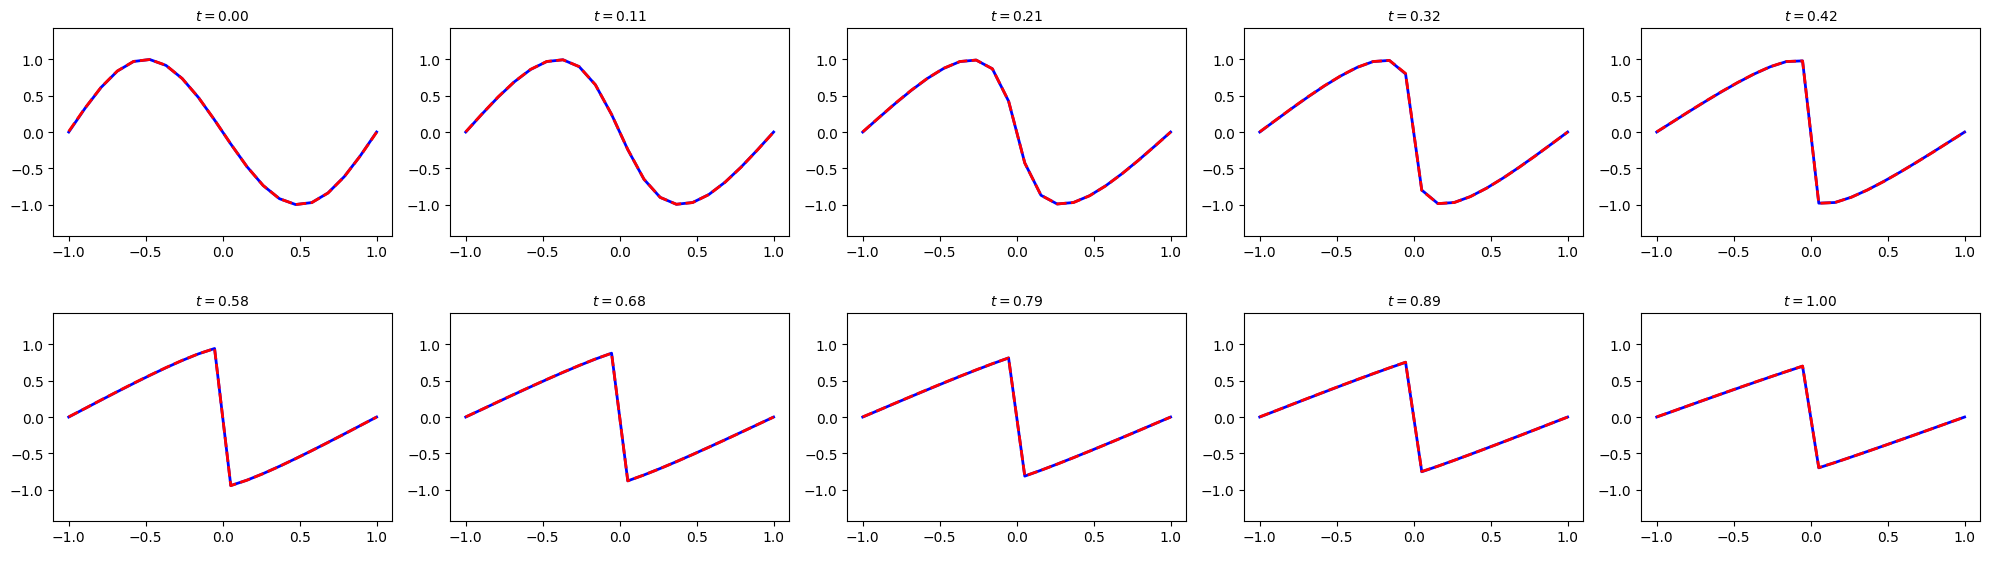

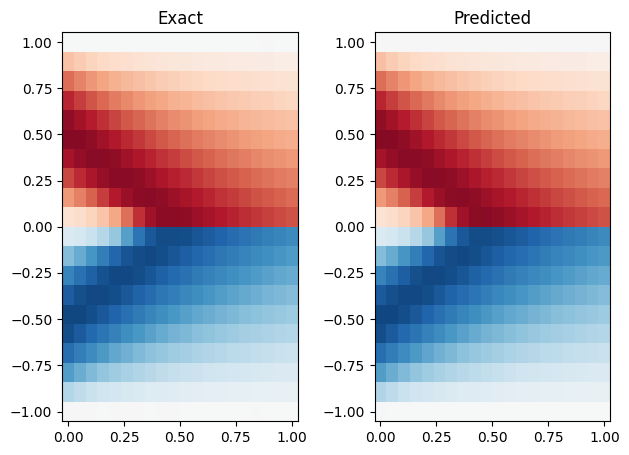

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.002691,0.000003,0.003797,0.000004


In [13]:
#Process results Viscous Burgers
nn.process_result(test_data,fit['u'],train_data,times = 10)

### **Example 2: Forward Advection Problem**

We will exemplify training PINN in JINNAX with the following Advection Problem:

  \begin{aligned}
  &u_t + \nu \ u_x = 0\,, \quad (x,t) \in (0,2\pi) \times (0,1]\,,\\
    &u(-1,t) = \sin(-1 - \nu t)\,, \quad t \in (0,1]\,,\\
    &u(1,t) = \sin(1 - \nu t)\,, \quad t \in (0,1]\,,\\
     &u(x,0) = \sin(x)\,, \quad x \in [0,2\pi]\,, \\
  \end{aligned}
for $\nu > 0$, whose solution is $u(x,t) = \sin(x - \nu t)$.

We consider again the forward problem, in which there are no sensor data, but the initial and boundary conditions are known.

In [14]:
#Parameters of the simulation
L =  2*np.pi
T = 1.0
v = 50.0

#Domain
xl = 0
xu = L
tl = 0.0
tu = T

#Compute analystical solution u(x,t)
def u(x,t):
    u = jnp.sin(x - v*t)
    return u

#PDE
def pde2(u,x,t):
  ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
  ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
  return ut(x,t) + v*ux(x,t)

#Generate train and test data
train_data2 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = None,Nts = None,Nb = 2,Ntb = 200,N0 = 400,Nc = 20,Ntc = 20)
test_data2 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 50,Nts = 50,train = False)

In [15]:
#Sample sizes
print('Sensor data: 0')
print('Initial data: ' + str(train_data2['initial'].shape[0]))
print('Boundary data: ' + str(train_data2['boundary'].shape[0]))
print('Collocation data: ' + str(train_data2['collocation'].shape[0]))

Sensor data: 0
Initial data: 400
Boundary data: 400
Collocation data: 400


In [16]:
#Train a PINN for 50000 epochs
width2 = [2] + 8 * [20] + [1]
fit2 = nn.train_PINN(data = train_data2,width = width2,pde = pde2,test_data = test_data2,epochs =  50000,epoch_print = 1000)

on 0: Time: 2 s Loss: 9.431625 L2 error: 2.140756
on 1000: Time: 4 s Loss: 0.98922 L2 error: 1.002854
on 2000: Time: 5 s Loss: 0.525431 L2 error: 0.975092
on 3000: Time: 6 s Loss: 0.447873 L2 error: 0.93583
on 4000: Time: 7 s Loss: 0.416835 L2 error: 0.90324
on 5000: Time: 9 s Loss: 0.376992 L2 error: 0.85504
on 6000: Time: 10 s Loss: 0.327421 L2 error: 0.803179
on 7000: Time: 12 s Loss: 0.301573 L2 error: 0.759632
on 8000: Time: 13 s Loss: 0.409445 L2 error: 0.723682
on 9000: Time: 14 s Loss: 0.237415 L2 error: 0.672797
on 10000: Time: 15 s Loss: 0.206143 L2 error: 0.645294
on 11000: Time: 16 s Loss: 0.202203 L2 error: 0.619889
on 12000: Time: 18 s Loss: 0.161097 L2 error: 0.578172
on 13000: Time: 19 s Loss: 0.143696 L2 error: 0.541324
on 14000: Time: 20 s Loss: 0.231122 L2 error: 0.477303
on 15000: Time: 22 s Loss: 0.085204 L2 error: 0.440048
on 16000: Time: 23 s Loss: 0.085475 L2 error: 0.420663
on 17000: Time: 25 s Loss: 0.061385 L2 error: 0.38283
on 18000: Time: 26 s Loss: 0.03652

L2 error test: 0.051439 L2 error train: 0.052518 MSE error test: 0.001323 MSE error train: 0.001381


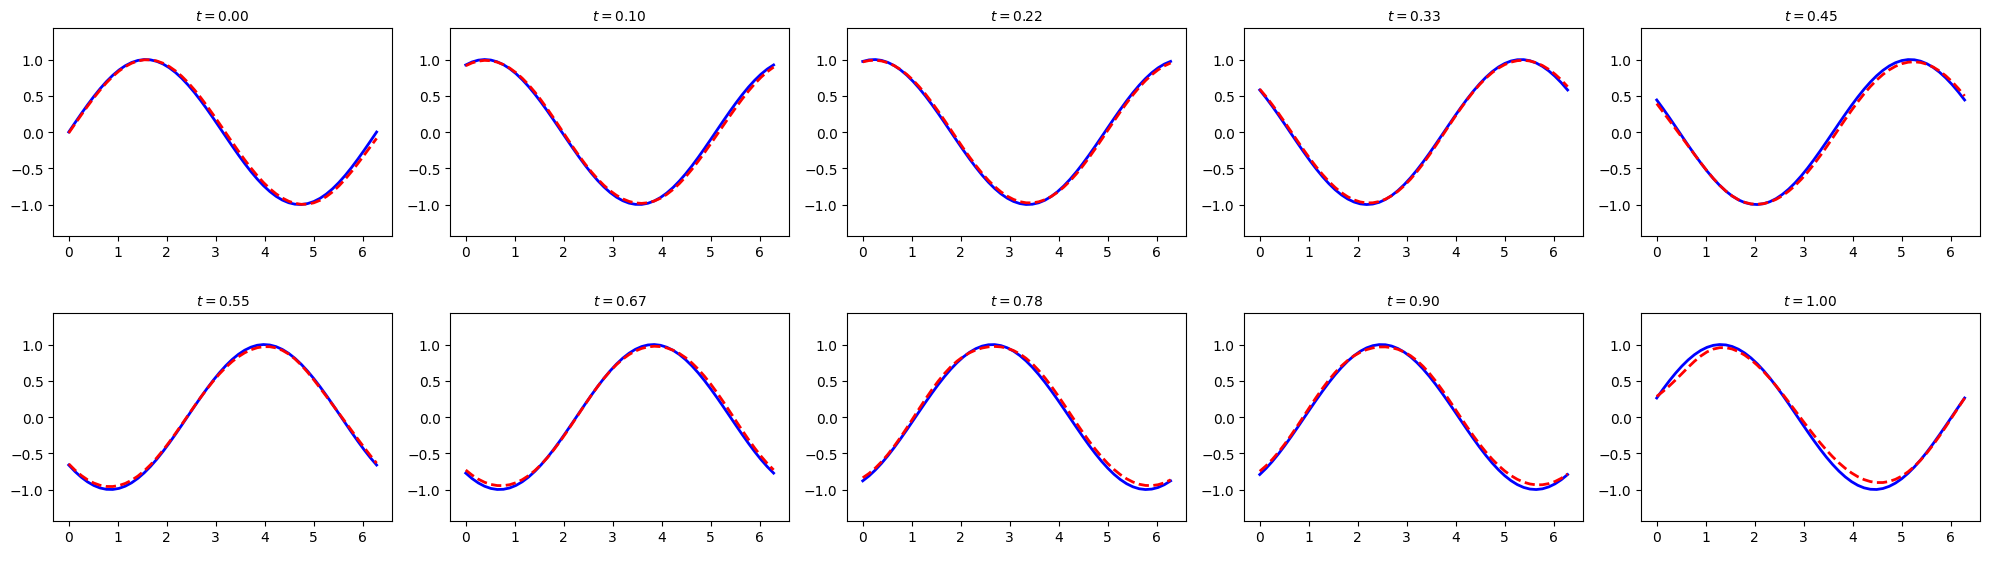

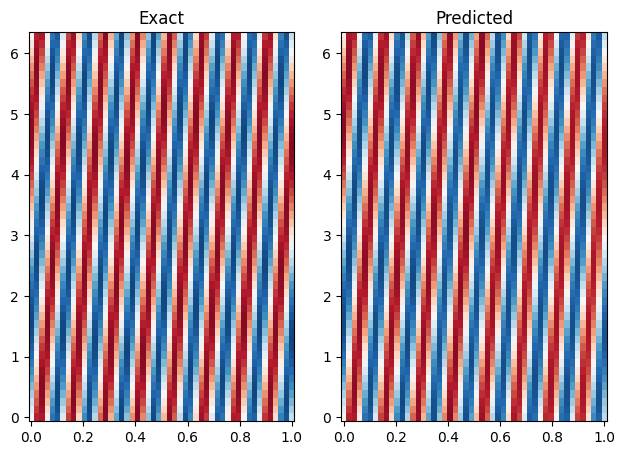

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.051439,0.001323,0.052518,0.001381


In [17]:
#Process Result
nn.process_result(test_data2,fit2['u'],train_data2,times = 10)

### **Example 3: Inverse Advection Problem**

Consider the inverse Advection Problem in which there are 20 sensors placed in a grid of $[0,2\pi]$ that captures the solution in 20 times in a grid of $[0,1]$ with a Gaussian noise of standard deviation $0.05$.

We eill train a PINN in JINNAX to approximate the solution with this data.

In [18]:
#Parameters of the simulation
L =  2*np.pi
T = 1.0
v = 50.0

#Domain
xl = 0
xu = L
tl = 0.0
tu = T

#Compute analystical solution u(x,t)
def u(x,t):
    u = jnp.sin(x - v*t)
    return u

#PDE
def pde3(u,x,t):
  ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
  ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
  return ut(x,t) + v*ux(x,t)

#Generate train and test data
train_data3 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 18,Nts = 19,Nb = 2,Ntb = 19,N0 = 20,Nc = 20,Ntc = 20,sigma0 = 0.05,sigmab = 0.05,sigmas = 0.05)
test_data3 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 50,Nts = 50,train = False)

In [19]:
#Sample sizes
print('Sensor data: ' + str(train_data3['sensor'].shape[0]))
print('Initial data: ' + str(train_data3['initial'].shape[0]))
print('Boundary data: ' + str(train_data3['boundary'].shape[0]))
print('Collocation data: ' + str(train_data3['collocation'].shape[0]))

Sensor data: 342
Initial data: 20
Boundary data: 38
Collocation data: 400


In [20]:
#Train a PINN for 50000 epochs
width3 = [2] + 8 * [20] + [1]
fit3 = nn.train_PINN(data = train_data3,width = width3,pde = pde3,test_data = test_data3,epochs =  50000,epoch_print = 1000)

on 0: Time: 2 s Loss: 11.619307 L2 error: 2.12524
on 1000: Time: 4 s Loss: 1.461243 L2 error: 1.000159
on 2000: Time: 5 s Loss: 1.454831 L2 error: 1.000693
on 3000: Time: 7 s Loss: 0.883524 L2 error: 0.925562
on 4000: Time: 9 s Loss: 0.728661 L2 error: 0.842465
on 5000: Time: 10 s Loss: 0.609194 L2 error: 0.764778
on 6000: Time: 11 s Loss: 0.479395 L2 error: 0.682369
on 7000: Time: 13 s Loss: 0.423115 L2 error: 0.64162
on 8000: Time: 14 s Loss: 0.356685 L2 error: 0.585066
on 9000: Time: 15 s Loss: 0.329175 L2 error: 0.537803
on 10000: Time: 17 s Loss: 0.272435 L2 error: 0.491957
on 11000: Time: 18 s Loss: 0.20014 L2 error: 0.441443
on 12000: Time: 20 s Loss: 0.31283998 L2 error: 0.418301
on 13000: Time: 22 s Loss: 0.106962 L2 error: 0.31592
on 14000: Time: 23 s Loss: 0.027097 L2 error: 0.128794
on 15000: Time: 24 s Loss: 0.032158 L2 error: 0.12976
on 16000: Time: 26 s Loss: 0.022231 L2 error: 0.117662
on 17000: Time: 27 s Loss: 0.019351 L2 error: 0.116309
on 18000: Time: 28 s Loss: 0.0

L2 error test: 0.039241 L2 error train: 0.070237 MSE error test: 0.00077 MSE error train: 0.00246


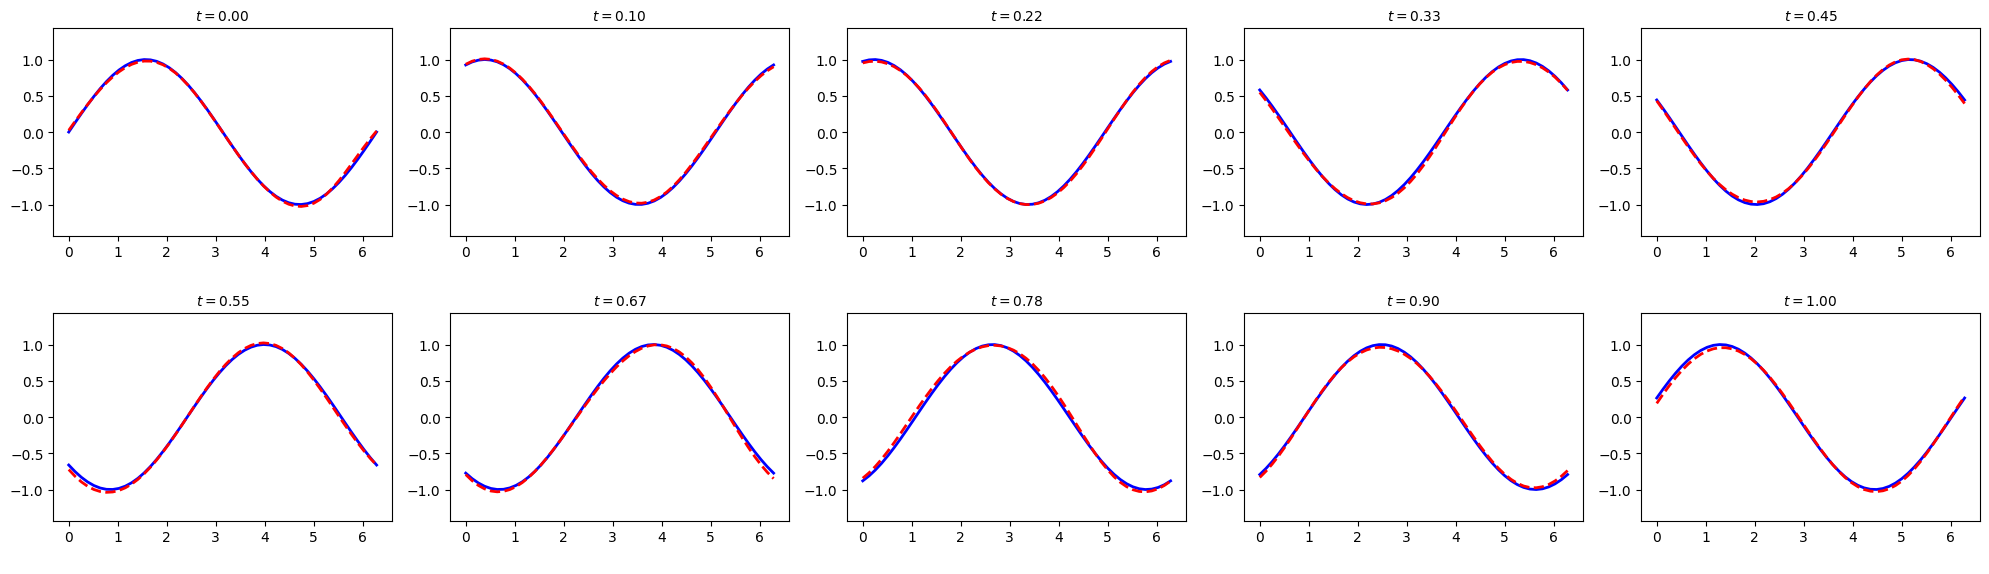

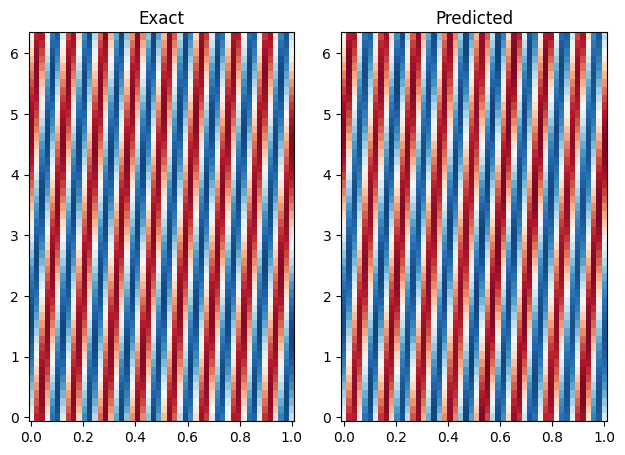

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.039241,0.00077,0.070237,0.00246


In [21]:
#Process Result
nn.process_result(test_data3,fit3['u'],train_data3,times = 10)

### **Example 4: Parameter Estimation in the Inverse Advection Problem**

Consider again the inverse Advection Problem in which there are 20 sensors placed in a grid of $[0,2\pi]$ that captures the solution in 20 times in a grid of $[0,1]$ with a Gaussian noise of standard deviation $0.05$. However, assume that the parameter $\nu$ is unknown and need to be estimated from this data.

We will train a PINN in JINNAX to estimate this parameter by minimizing the PINN loss with respect to the neural network parameters and $\nu$.

In [22]:
#Parameters of the simulation
L =  2*np.pi
T = 1.0
v = 50.0

#Domain
xl = 0
xu = L
tl = 0.0
tu = T

#Compute analystical solution u(x,t)
def u(x,t):
    u = jnp.sin(x - v*t)
    return u

#PDE
def pde4(u,x,t,v):
  ux = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),0)(x,t)
  ut = lambda x,t : jax.grad(lambda x,t : jnp.sum(u(x,t)),1)(x,t)
  return ut(x,t) + 100*jax.nn.sigmoid(v)*ux(x,t)

#Initial value for nu
v0 = 0.5

#Generate train and test data
train_data4 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 18,Nts = 19,Nb = 2,Ntb = 19,N0 = 20,Nc = 20,Ntc = 20,sigma0 = 0.05,sigmab = 0.05,sigmas = 0.05)
test_data4 = jd.generate_PINNdata(u = u,xl = xl,xu = xu,tl = tl,tu = tu,Ns = 50,Nts = 50,train = False)

In [23]:
#Sample sizes
print('Sensor data: ' + str(train_data3['sensor'].shape[0]))
print('Initial data: ' + str(train_data3['initial'].shape[0]))
print('Boundary data: ' + str(train_data3['boundary'].shape[0]))
print('Collocation data: ' + str(train_data3['collocation'].shape[0]))

Sensor data: 342
Initial data: 20
Boundary data: 38
Collocation data: 400


In [24]:
#Train a PINN for 50000 epochs
width4 = [2] + 8 * [20] + [1]
fit4 = nn.train_PINN(data = train_data4,width = width4,pde = pde4,test_data = test_data4,epochs =  50000,epoch_print = 1000,inverse = True,initial_par = v0)

on 0: Time: 3 s Loss: 14.343376 L2 error: 2.141119 Parameter: 0.499
on 1000: Time: 7 s Loss: 1.458144 L2 error: 1.000013 Parameter: 0.485594
on 2000: Time: 9 s Loss: 1.45561 L2 error: 1.000518 Parameter: 0.474291
on 3000: Time: 10 s Loss: 1.443837 L2 error: 1.000768 Parameter: 0.43797
on 4000: Time: 12 s Loss: 0.86432 L2 error: 0.924148 Parameter: 0.213814
on 5000: Time: 13 s Loss: 0.735015 L2 error: 0.853103 Parameter: 0.139203
on 6000: Time: 15 s Loss: 0.63927 L2 error: 0.782561 Parameter: 0.083136
on 7000: Time: 16 s Loss: 0.505752 L2 error: 0.69527197 Parameter: 0.047231
on 8000: Time: 18 s Loss: 0.452067 L2 error: 0.668154 Parameter: 0.030025
on 9000: Time: 19 s Loss: 0.384896 L2 error: 0.614775 Parameter: 0.017055
on 10000: Time: 21 s Loss: 0.354882 L2 error: 0.585701 Parameter: 0.006384
on 11000: Time: 22 s Loss: 0.336015 L2 error: 0.574934 Parameter: -0.000467
on 12000: Time: 23 s Loss: 0.325665 L2 error: 0.558759 Parameter: -0.002082
on 13000: Time: 25 s Loss: 0.211468 L2 erro

L2 error test: 0.04837 L2 error train: 0.074797 MSE error test: 0.001169 MSE error train: 0.002791


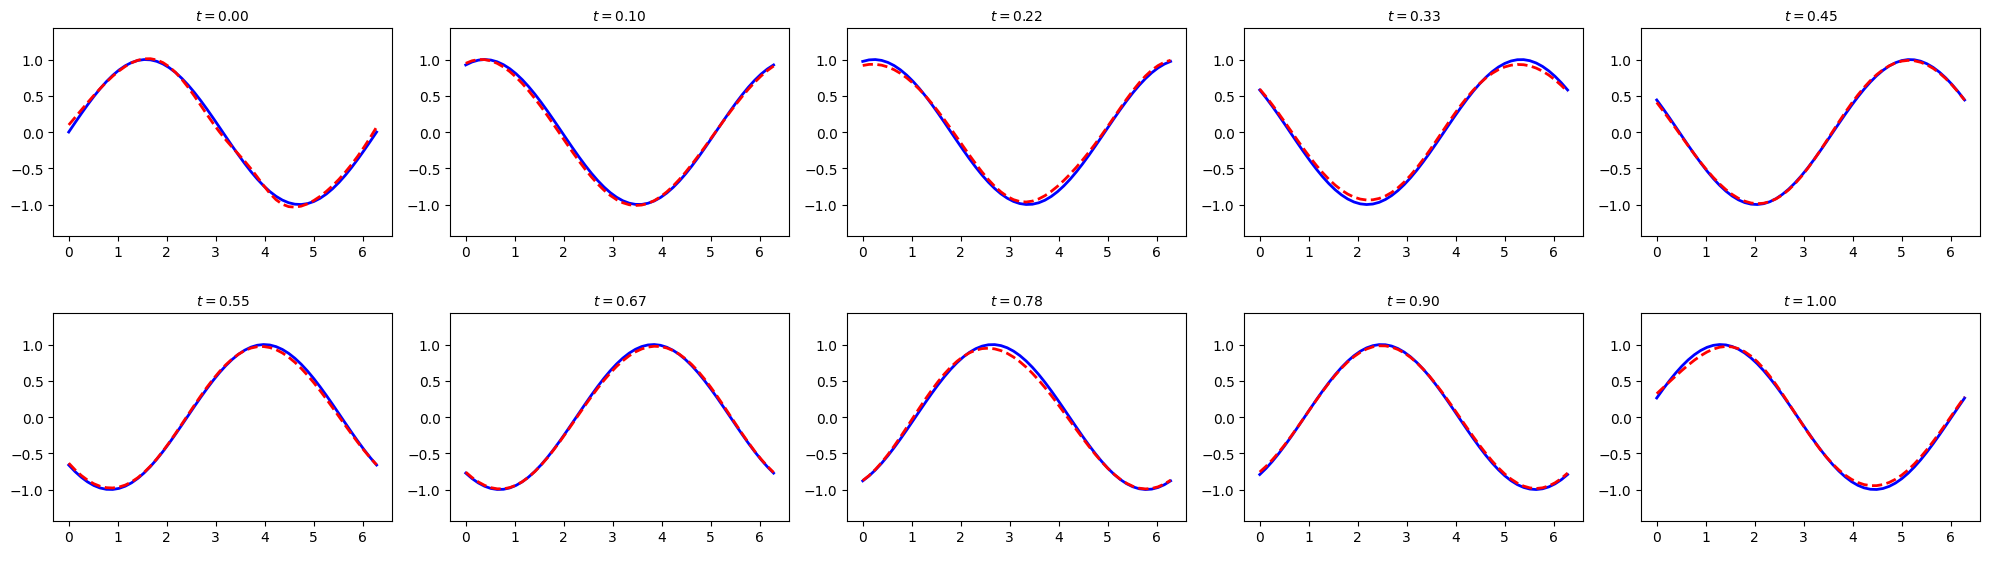

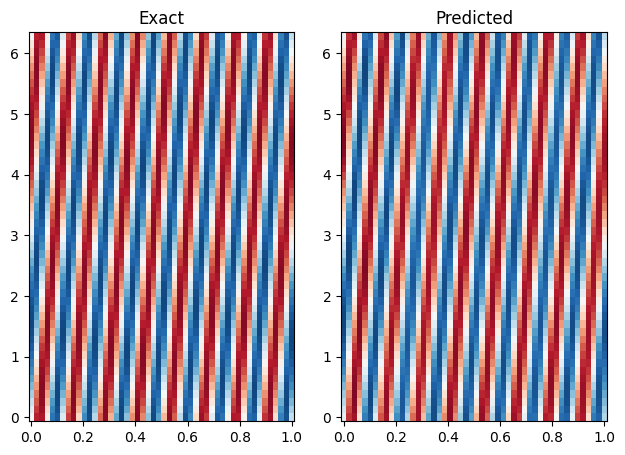

,l2_error_test,MSE_test,l2_error_train,MSE_train
0,0.04837,0.001169,0.074797,0.002791


In [25]:
#Process Result
nn.process_result(test_data4,fit4['u'],train_data4,times = 10)